In [4]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

In [5]:
class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=1,num_layers=3,dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        
        #mask = self._generate_square_subsequent_mask(len(src)).to('cuda')
        #output = self.transformer_encoder(src,mask)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

In [6]:
data = np.loadtxt("./lienard_intermittency.dat")

train = data[:, 1][:45000]
test =  data[:, 1][45000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [7]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [8]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [9]:
model = Transformer().to('cuda')

In [10]:
from IPython.display import clear_output

In [23]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

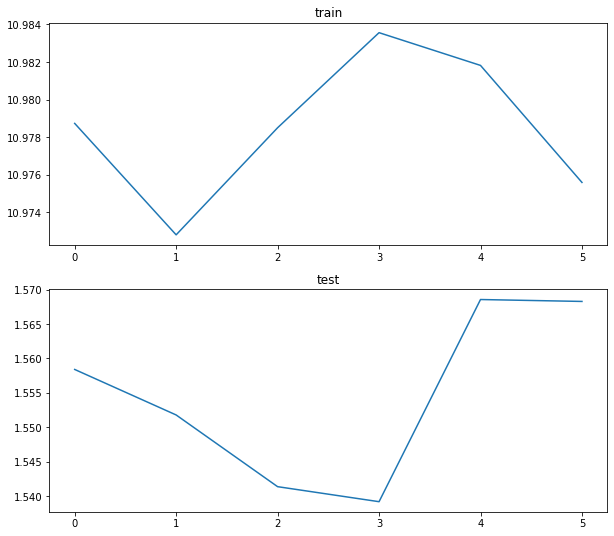

Epoch[6/200] | loss train:10.975587, test:1.568282


KeyboardInterrupt: 

In [24]:


# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    #scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))

In [19]:
def ShowPredict(model1, k):
    train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    test_right_part = (len(test)- 20)%64
    predicted_val = np.array([])
    for idx, (x, y) in enumerate(val_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        cur_x = x
        for _ in range(k):
            out = model1(cur_x.to('cuda'))
            cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
        predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
        
    
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1.plot(test_norm[20+k-1:], label='true')
    if k == 1:
        ax_1.plot(predicted_val[:],  linestyle = '--', label='predicted')
    else:
        ax_1.plot(predicted_val[:-k+1],  linestyle = '--', label='predicted')
    ax_1.legend()
    
    
    plt.show()

In [20]:
ShowPredict(model, 1)

RuntimeError: shape '[64, 1, 1]' is invalid for input of size 1280